## Partie 1 : Exploration et Preparation des Donnees

### 1.1 Chargement et exploration

- Chargez le dataset et affichez ses caracteristiques principales
- Combien y a-t-il d'echantillons par classe ?
- Les classes sont-elles equilibrees ?

In [19]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

Entre 174 et 183 valeurs par classe


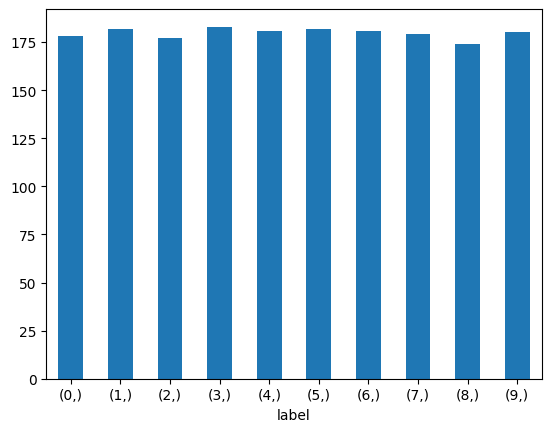

In [20]:
import pandas as pd

df_y = pd.DataFrame(data=y, columns=["label"], index=range(len(y)))

df_y.value_counts().sort_index().plot(kind="bar", rot=0)
print(
    f"Entre {df_y.value_counts().min()} et {df_y.value_counts().max()} valeurs par classe"
)

- Classes plutôt équilibrées

### 1.2 Visualisation des images

- Affichez une grille de 25 images (5x5) avec leurs labels
- Utilisez `plt.imshow()` avec `cmap='gray'`
- Les images `digits.images` sont de dimension 8x8

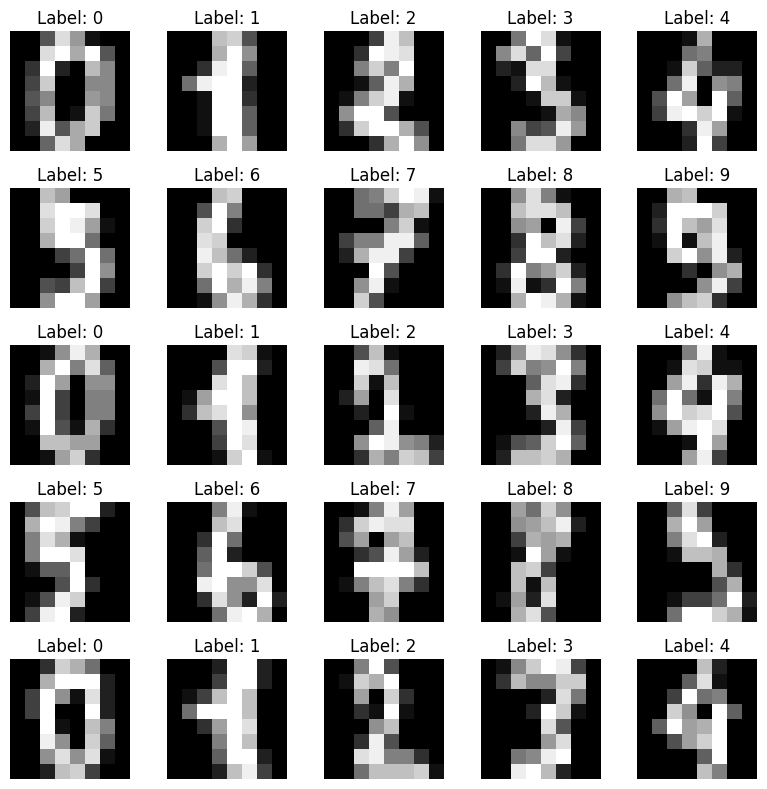

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for k in range(25):
    ax = axes[k // 5, k % 5]
    ax.imshow(digits.images[k], cmap="gray")
    ax.set_title(f"Label: {digits.target[k]}")
    ax.set_axis_off()
plt.tight_layout()

### 1.3 Preparation

- Divisez les donnees en train (80%) et test (20%)
- Utilisez `stratify=y` pour conserver la distribution des classes
- Normalisez les donnees avec `StandardScaler`

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, stratify=y
)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

## Partie 2 : Classification avec KNN

### 2.1 Premier modele

- Entrainez un KNN avec K=5, n_jobs=-1, algorithm='kd_tree'
- Evaluez avec accuracy et rapport de classification

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "clasifier",
            KNeighborsClassifier(n_neighbors=5, n_jobs=-1, algorithm="kd_tree"),
        ),
    ],
)

In [25]:
from sklearn.metrics import accuracy_score, classification_report
import time

start_time_knn = time.time()
knn_pipeline.fit(X_train, y_train)
end_time_knn = time.time()

y_pred_train_knn = knn_pipeline.predict(X_train)
y_pred_test_knn = knn_pipeline.predict(X_test)

print("Execution time: ", end_time_knn - start_time_knn)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train_knn))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_knn))


Execution time:  0.008539915084838867
Accuracy train:  0.9839944328462074
Accuracy test:  0.9638888888888889
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      1.00      0.96        36
           2       0.95      1.00      0.97        35
           3       1.00      0.97      0.99        37
           4       0.97      0.94      0.96        36
           5       0.97      0.97      0.97        37
           6       0.97      1.00      0.99        36
           7       0.92      0.97      0.95        36
           8       0.97      0.89      0.93        35
           9       0.97      0.89      0.93        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



### 2.2 Optimisation de K

- Testez K de 1 a 20
- Tracez la courbe du score en fonction de K
- Quel est le K optimal ?

K optimal:  13


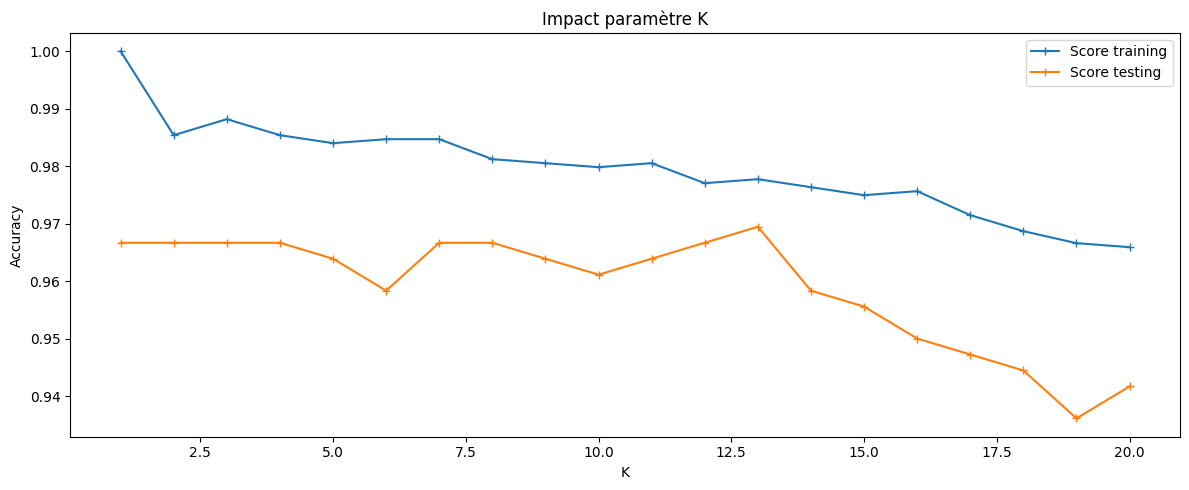

In [ ]:
k_values = range(1, 21)
train_score = []
test_score = []

for k in k_values:
    knn = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm="kd_tree"),
            ),
        ]
    )
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))

plt.figure(figsize=(12, 5))
plt.plot(k_values, train_score, label="Score training", marker="+")
plt.plot(k_values, test_score, label="Score testing", marker="+")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Impact paramètre K")
plt.legend()
plt.tight_layout()

k_optimal = k_values[test_score.index(max(test_score))]
print("K optimal: ", k_optimal)

### 2.3 Analyse des erreurs

- Creez la matrice de confusion
- Visualisez-la avec `seaborn.heatmap()`

Execution time:  0.008146047592163086
Accuracy train:  0.977731384829506
Accuracy test:  0.9694444444444444
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.90      0.97      0.93        36
           2       0.97      1.00      0.99        35
           3       1.00      0.97      0.99        37
           4       0.97      0.97      0.97        36
           5       0.95      0.97      0.96        37
           6       0.97      1.00      0.99        36
           7       0.97      0.97      0.97        36
           8       1.00      0.89      0.94        35
           9       0.97      0.94      0.96        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



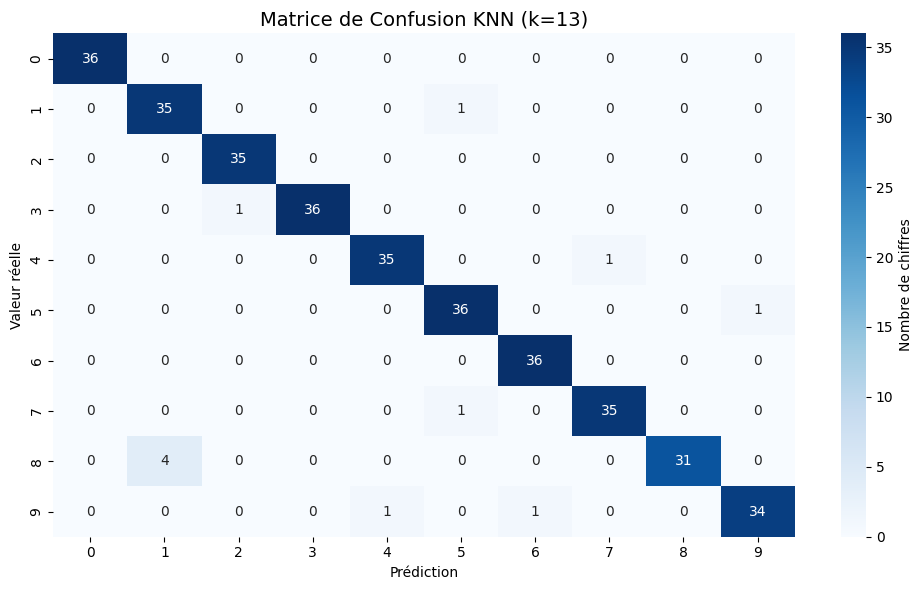

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

knn_pipeline_optimal = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            KNeighborsClassifier(n_neighbors=k_optimal, n_jobs=-1, algorithm="kd_tree"),
        ),
    ]
)

start_time_knn_optimal = time.time()
knn_pipeline_optimal.fit(X_train, y_train)
end_time_knn_optimal = time.time()

y_pred_train_knn_optimal = knn_pipeline_optimal.predict(X_train)
y_pred_test_knn_optimal = knn_pipeline_optimal.predict(X_test)

print("Execution time: ", end_time_knn_optimal - start_time_knn_optimal)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train_knn_optimal))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test_knn_optimal))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_knn_optimal))

cm_knn_optimal = confusion_matrix(y_test, y_pred_test_knn_optimal)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm_knn_optimal,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion KNN (k=13)", fontsize=14)

plt.tight_layout()

## Partie 3 : Classification avec Arbres de Decision

### 3.1 Arbre de base

- Entrainez un arbre sans contrainte
- Comparez accuracy train et test

Execution time:  0.013276338577270508
Accuracy train:  0.9679888656924147
Accuracy test:  0.8138888888888889
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        36
           1       0.71      0.75      0.73        36
           2       0.87      0.77      0.82        35
           3       0.82      0.84      0.83        37
           4       0.85      0.78      0.81        36
           5       0.90      0.95      0.92        37
           6       0.83      0.83      0.83        36
           7       0.83      0.81      0.82        36
           8       0.64      0.71      0.68        35
           9       0.81      0.72      0.76        36

    accuracy                           0.81       360
   macro avg       0.82      0.81      0.81       360
weighted avg       0.82      0.81      0.81       360



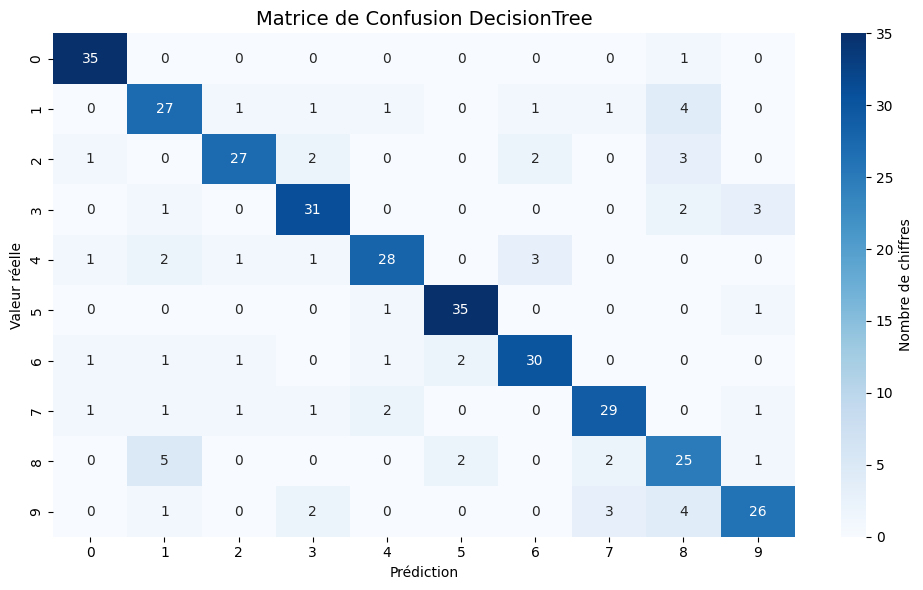

In [39]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clasifier", DecisionTreeClassifier(random_state=42, max_depth=9)),
    ],
)

start_time_dt = time.time()
dt_pipeline.fit(X_train, y_train)
end_time_dt = time.time()

y_pred_train_dt = dt_pipeline.predict(X_train)
y_pred_test_dt = dt_pipeline.predict(X_test)

print("Execution time: ", end_time_dt - start_time_dt)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train_dt))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test_dt))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_dt))

cm_dt = confusion_matrix(y_test, y_pred_test_dt)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm_dt,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion DecisionTree", fontsize=14)

plt.tight_layout()

depth optimal:  14


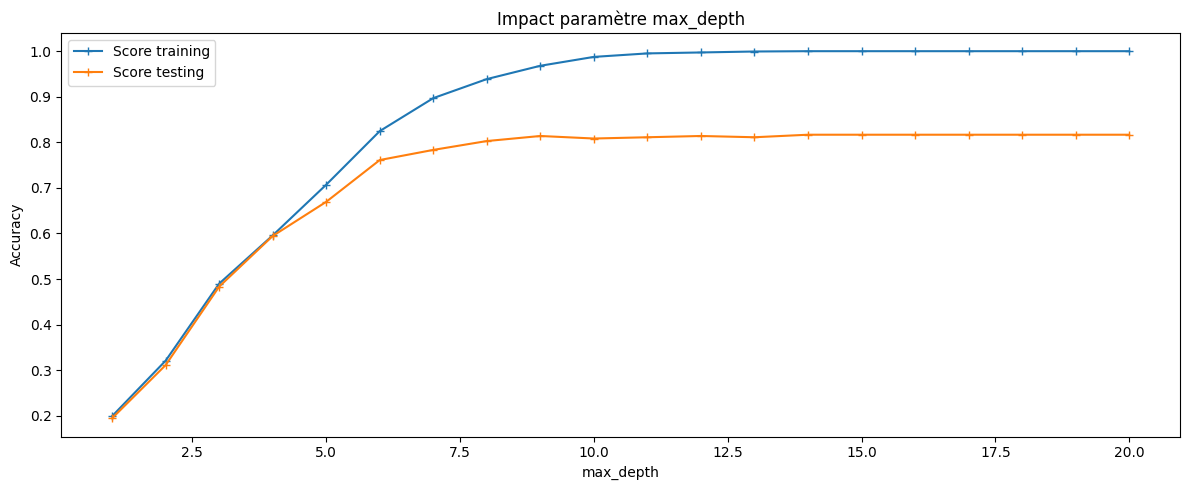

In [ ]:
depth_values = range(1, 21)
train_score = []
test_score = []

for depth in depth_values:
    dt = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                DecisionTreeClassifier(random_state=42, max_depth=depth),
            ),
        ]
    )
    dt.fit(X_train, y_train)
    train_score.append(dt.score(X_train, y_train))
    test_score.append(dt.score(X_test, y_test))

plt.figure(figsize=(12, 5))
plt.plot(depth_values, train_score, label="Score training", marker="+")
plt.plot(depth_values, test_score, label="Score testing", marker="+")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Impact paramètre max_depth")
plt.legend()
plt.tight_layout()

depth_optimal = depth_values[test_score.index(max(test_score))]
print("depth optimal: ", depth_optimal)

### 3.2 Comparaison avec KNN

- Quelle methode est meilleure sur ce probleme ?
  -> La meilleur méthode est KNN
- Quels sont les avantages et inconvenients de chaque approche ?
  -> Il semblerait que KNN n'ait aucun inconvenients ici; KNN est plus rapide et donne de meilleurs résultats que DecisionTree

## Partie 4 : Methodes d'Ensemble

### 4.1 Random Forest

- Entrainez un Random Forest avec 100 arbres
- Comparez avec l'arbre simple et KNN

Execution time:  0.7643485069274902
Accuracy train:  1.0
Accuracy test:  0.9722222222222222
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.92      1.00      0.96        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.94      0.86      0.90        35
           9       1.00      0.92      0.96        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



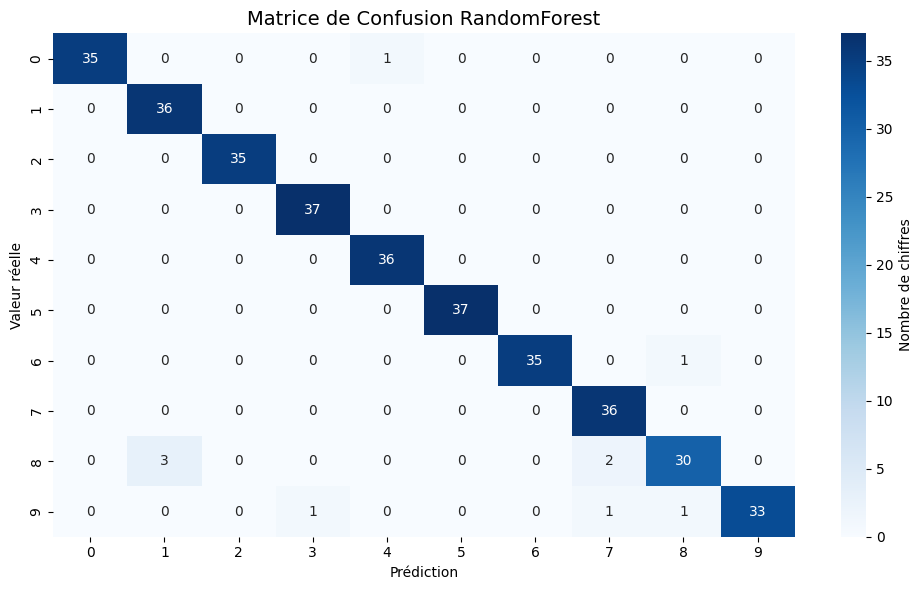

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clasifier", RandomForestClassifier(random_state=42, n_estimators=400)),
    ],
)

start_time_rf = time.time()
rf_pipeline.fit(X_train, y_train)
end_time_rf = time.time()

y_pred_train_rf = rf_pipeline.predict(X_train)
y_pred_test_rf = rf_pipeline.predict(X_test)

print("Execution time: ", end_time_rf - start_time_rf)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train_rf))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_rf))

cm_rf = confusion_matrix(y_test, y_pred_test_rf)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion RandomForest", fontsize=14)

plt.tight_layout()

n_estimator optimal:  400


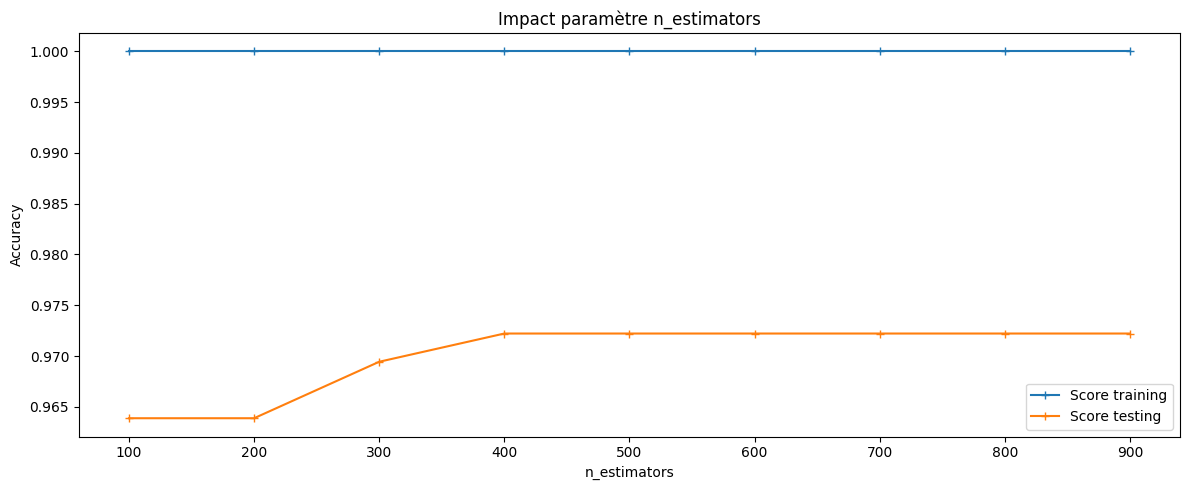

In [45]:
estimators_values = range(100, 1000, 100)
train_score = []
test_score = []

for estimators in estimators_values:
    rf = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                RandomForestClassifier(random_state=42, n_estimators=estimators),
            ),
        ]
    )
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test, y_test))

plt.figure(figsize=(12, 5))
plt.plot(estimators_values, train_score, label="Score training", marker="+")
plt.plot(estimators_values, test_score, label="Score testing", marker="+")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Impact paramètre n_estimators")
plt.legend()
plt.tight_layout()

estimator_optimal = estimators_values[test_score.index(max(test_score))]
print("n_estimator optimal: ", estimator_optimal)

- ForestTree semble meilleur de KNN

### 4.2 Gradient Boosting

- Entrainez un GradientBoostingClassifier
- Attention : peut etre lent sur ce dataset
- Comparez avec Random Forest

Execution time:  4.035926580429077
Accuracy train:  1.0
Accuracy test:  0.9527777777777777
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.94      0.83      0.88        36
           2       0.97      0.97      0.97        35
           3       0.97      1.00      0.99        37
           4       1.00      0.97      0.99        36
           5       0.97      1.00      0.99        37
           6       0.97      0.94      0.96        36
           7       0.92      1.00      0.96        36
           8       0.89      0.91      0.90        35
           9       0.94      0.92      0.93        36

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



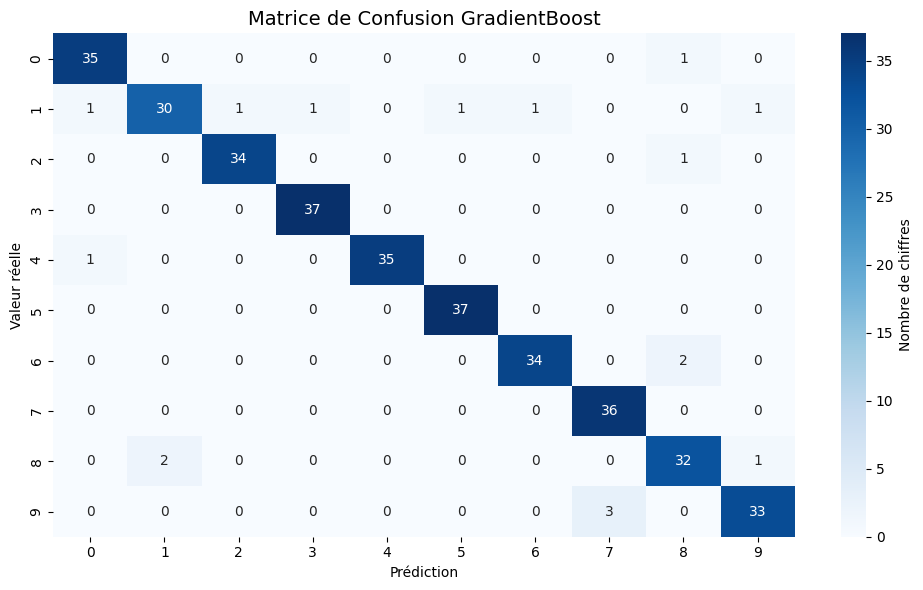

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clasifier", GradientBoostingClassifier(random_state=42)),
    ],
)

start_time_gb = time.time()
gb_pipeline.fit(X_train, y_train)
end_time_gb = time.time()

y_pred_train_gb = gb_pipeline.predict(X_train)
y_pred_test_gb = gb_pipeline.predict(X_test)

print("Execution time: ", end_time_gb - start_time_gb)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train_gb))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test_gb))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_gb))

cm_gb = confusion_matrix(y_test, y_pred_test_gb)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm_gb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion GradientBoost", fontsize=14)

plt.tight_layout()

- GradientBoost ne semble pas plus performant que ForestTree

### 4.4 Voting Classifier

- Combinez vos 3 meilleurs modeles dans un VotingClassifier
- Testez `voting='hard'` et `voting='soft'`
- Le voting bat-il les modeles individuels ?

Execution time:  4.236078262329102
Accuracy train:  1.0
Accuracy test:  0.9777777777777777
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.94      0.94      0.94        36
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        37
           4       1.00      1.00      1.00        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.95      1.00      0.97        36
           8       0.94      0.94      0.94        35
           9       1.00      0.94      0.97        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



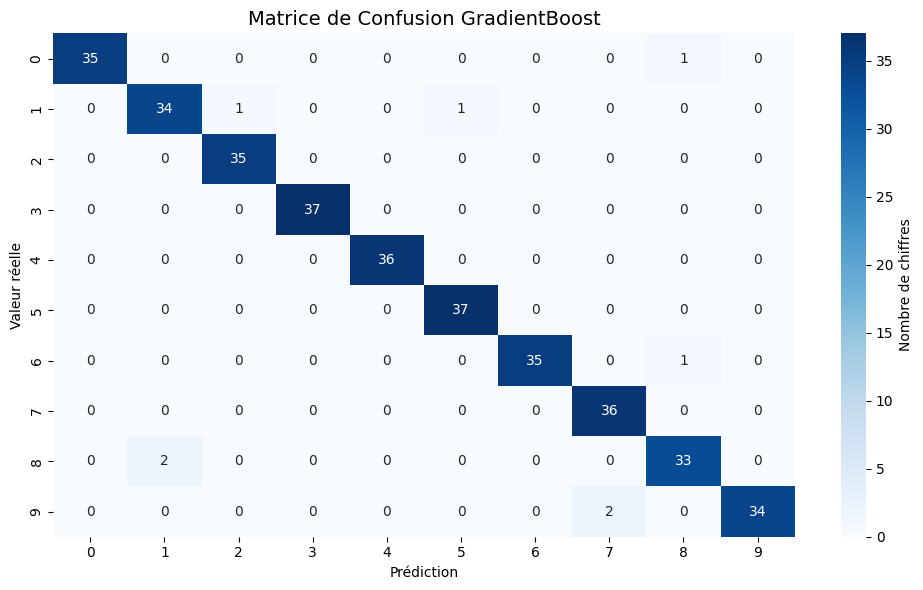

In [32]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ("knn", KNeighborsClassifier(n_neighbors=13, n_jobs=-1, algorithm="kd_tree")),
    ("rf", RandomForestClassifier(random_state=42)),
    ("gb", GradientBoostingClassifier(random_state=42)),
]

vot_pipeline_soft = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("vot", VotingClassifier(estimators=estimators, voting="soft")),
    ]
)

start_time_vot_soft = time.time()
vot_pipeline_soft.fit(X_train, y_train)
end_time_vot_soft = time.time()

y_pred_train_vot_soft = vot_pipeline_soft.predict(X_train)
y_pred_test_vot_soft = vot_pipeline_soft.predict(X_test)

print("Execution time: ", end_time_vot_soft - start_time_vot_soft)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train_vot_soft))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test_vot_soft))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_vot_soft))

cm_vot_soft = confusion_matrix(y_test, y_pred_test_vot_soft)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm_vot_soft,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion GradientBoost", fontsize=14)

plt.tight_layout()

Execution time:  4.220026969909668
Accuracy train:  1.0
Accuracy test:  0.9833333333333333
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      0.97      0.95        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       1.00      1.00      1.00        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.97      1.00      0.99        36
           8       0.97      0.91      0.94        35
           9       1.00      0.97      0.99        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



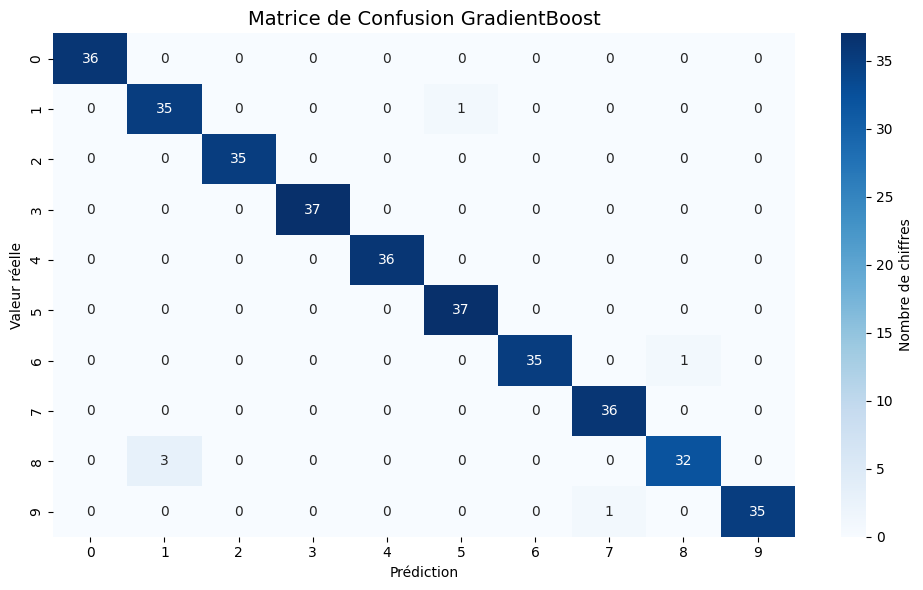

In [33]:
vot_pipeline_hard = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("vot", VotingClassifier(estimators=estimators, voting="hard")),
    ]
)

start_time_vot_hard = time.time()
vot_pipeline_hard.fit(X_train, y_train)
end_time_vot_hard = time.time()

y_pred_train_vot_hard = vot_pipeline_hard.predict(X_train)
y_pred_test_vot_hard = vot_pipeline_hard.predict(X_test)

print("Execution time: ", end_time_vot_hard - start_time_vot_hard)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train_vot_hard))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test_vot_hard))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_vot_hard))

cm_vot_hard = confusion_matrix(y_test, y_pred_test_vot_hard)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm_vot_hard,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion GradientBoost", fontsize=14)

plt.tight_layout()

## Partie 5 : Pipeline Final

### 5.1 Meilleur modele

- Choisissez le meilleur algorithme base sur vos experimentations
  -> Le modèle VotingClassifier avec le paramètre voting="hard" semble le plus performant

### 5.2 Pipeline complet

- Creez un pipeline incluant :
  - Le preprocessing (StandardScaler si necessaire)
  - Le modele optimise
- Evaluez le pipeline final sur le jeu de test

### 5.4 Rapport de performance

Creez un tableau recapitulatif :

| Modele                  | Accuracy | Temps (s) | Meilleur pour |
| ----------------------- | -------- | --------- | ------------- |
| KNN (K=?)               |          |           |               |
| Decision Tree (depth=?) |          |           |               |
| Random Forest (n=?)     |          |           |               |
| Gradient Boosting       |          |           |               |
| Voting                  |          |           |               |

In [48]:
data = {
    "Modele": ["KNN", "DecisionTree", "RandomForest", "GradientBoosting", "Voting"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_test_knn_optimal),
        accuracy_score(y_test, y_pred_test_dt),
        accuracy_score(y_test, y_pred_test_rf),
        accuracy_score(y_test, y_pred_test_gb),
        accuracy_score(y_test, y_pred_test_vot_hard),
    ],
    "Temps": [
        abs(start_time_knn_optimal - end_time_knn_optimal),
        abs(start_time_dt - end_time_dt),
        abs(start_time_rf - end_time_rf),
        abs(start_time_gb - end_time_gb),
        abs(start_time_vot_hard - end_time_vot_hard),
    ],
    "Meilleur pour": ["k=13", "depth=9", "n=400", "", "voting=hard"],
}

results = pd.DataFrame(data)
results.head()

,Modele,Accuracy,Temps,Meilleur pour
0,KNN,0.969444,0.008146,k=13
1,DecisionTree,0.813889,0.013276,depth=9
2,RandomForest,0.972222,0.764349,n=400
3,GradientBoosting,0.952778,4.035927,
4,Voting,0.983333,4.220027,voting=hard


### 5.6 Modele sauvegarde

- Sauvegardez votre meilleur modele avec `joblib`
- Incluez le code pour charger et utiliser le modele

In [49]:
import joblib

model_file_name = (
    "C:/Users/Administrateur/Documents/M2i_CDSD_TDTP/scikit_learn/exos/tp3.pkl"
)
joblib.dump(vot_pipeline_hard, model_file_name)

['C:/Users/Administrateur/Documents/M2i_CDSD_TDTP/scikit_learn/exos/tp3.pkl']